In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import cvxpy as cp
import gurobipy

In [2]:
dh_s = 120*60
initial_storage_MW = 0.0
max_storage_MW = 100e3

n_sources = 6

N = 12
Ts = []
for ii in range(0,288, int(288/N)):
    Ts.append(ii)

In [3]:
Ts_tr = np.array([], dtype='float')
solar_tr = np.array([], dtype='float')
wind_tr = np.array([], dtype='float')
geothermal_tr = np.array([], dtype='float')
biomass_tr = np.array([], dtype='float')
biogas_tr = np.array([], dtype='float')
small_hydro_tr = np.array([], dtype='float')
non_renewables_tr = np.array([], dtype='float')

data_tr = np.zeros((0,n_sources), dtype='float')

for ii in [4,3,2,0,1]:
    str_ii = str(ii+1).zfill(2)
    supply_df = pd.read_csv('data/CAISO-supply-2021{}20.csv'.format(str_ii))
    demand_df = pd.read_csv('data/CAISO-demand-2021{}20.csv'.format(str_ii))
    renewables_df = pd.read_csv('data/CAISO-renewables-2021{}20.csv'.format(str_ii))

    natural_gas = supply_df.iloc[1].values[1:-1][Ts]
    large_hydro = supply_df.iloc[2].values[1:-1][Ts]
    imports = supply_df.iloc[3].values[1:-1][Ts]
    batteries = supply_df.iloc[4].values[1:-1][Ts]
    nuclear = supply_df.iloc[5].values[1:-1][Ts]
    coal = supply_df.iloc[6].values[1:-1][Ts]
    other = supply_df.iloc[7].values[1:-1][Ts]

    solar = renewables_df.iloc[0].values[1:][Ts]
    wind = renewables_df.iloc[1].values[1:][Ts]
    geothermal = renewables_df.iloc[2].values[1:][Ts]
    biomass = renewables_df.iloc[3].values[1:][Ts]
    biogas = renewables_df.iloc[4].values[1:][Ts]
    small_hydro = renewables_df.iloc[5].values[1:][Ts]

    renewables = supply_df.iloc[0].values[1:-1][Ts]
    non_renewables = natural_gas + large_hydro + imports + batteries + nuclear + coal + other

    hour_ahead_forecast = demand_df.iloc[1].values[1:-1][Ts]

    Ts_tr = np.append(Ts_tr, np.array(Ts))
    solar_tr = np.append(solar_tr, solar.astype(float))
    wind_tr = np.append(wind_tr, wind.astype(float))

    renewables_tr = np.vstack((solar, wind, geothermal, biomass, biogas, small_hydro)).T
    renewables_tr = np.maximum(renewables_tr, 0)
    data_tr = np.vstack((data_tr, renewables_tr))

In [334]:
ii = 3
str_ii = str(ii+1).zfill(2)
supply_df = pd.read_csv('data/CAISO-supply-2021{}20.csv'.format(str_ii))
demand_df = pd.read_csv('data/CAISO-demand-2021{}20.csv'.format(str_ii))
renewables_df = pd.read_csv('data/CAISO-renewables-2021{}20.csv'.format(str_ii))

natural_gas = supply_df.iloc[1].values[1:-1][Ts]
large_hydro = supply_df.iloc[2].values[1:-1][Ts]
imports = supply_df.iloc[3].values[1:-1][Ts]
batteries = supply_df.iloc[4].values[1:-1][Ts]
nuclear = supply_df.iloc[5].values[1:-1][Ts]
coal = supply_df.iloc[6].values[1:-1][Ts]
other = supply_df.iloc[7].values[1:-1][Ts]

solar = renewables_df.iloc[0].values[1:][Ts]
wind = renewables_df.iloc[1].values[1:][Ts]
geothermal = renewables_df.iloc[2].values[1:][Ts]
biomass = renewables_df.iloc[3].values[1:][Ts]
biogas = renewables_df.iloc[4].values[1:][Ts]
small_hydro = renewables_df.iloc[5].values[1:][Ts]

renewables = supply_df.iloc[0].values[1:-1][Ts]
non_renewables = natural_gas + large_hydro + imports + batteries + nuclear + coal + other

n_sources = 13
supply = np.zeros((n_sources, len(Ts)))
supply[0] = solar
supply[1] = wind
supply[2] = geothermal
supply[3] = biomass
supply[4] = biogas
supply[5] = small_hydro
supply[6] = natural_gas
supply[7] = large_hydro
supply[8] = imports
supply[9] = batteries
supply[10] = nuclear
supply[11] = coal
supply[12] = other

cost_series = 100000.0 * np.ones(N-1)

day_ahead_forecast = demand_df.iloc[0].values[1:-1][Ts]
hour_ahead_forecast = demand_df.iloc[1].values[1:-1][Ts]
# demand = demand_df.iloc[2].values[1:-1]

In [335]:
in_storage = cp.Variable(N+1)
store_in = cp.Variable(N)
store_out = cp.Variable(N)
buy = cp.Variable((n_sources,N))

M_ = 1e8
y = cp.Variable((n_sources,N), boolean=True)

In [336]:
cons = []

# Upper and lower bounds
cons += [in_storage >= 0.0]
cons += [in_storage <= max_storage_MW]
cons += [store_in >= 0.0]
cons += [store_out >= 0.0]
cons += [buy >= 0.0]
cons += [discharge_cost >= 0.0]

# Storage initialization constraint
cons += [in_storage[0] == initial_storage_MW]

for ii in range(N):
    # Available power constraint
    for jj in range(n_sources):
        cons += [buy[jj,ii] <= np.maximum(supply[jj,ii], 0.0)]

    # Storage conservation of energy
    cons += [in_storage[ii+1] == in_storage[ii] + store_in[ii] - store_out[ii]]

    # Sufficiency constraint
    cons += [sum(buy[:,ii]) - store_in[ii] + store_out[ii] >= hour_ahead_forecast[ii]]

    # Store-in constraint
    cons += [store_in[ii] <= sum(buy[:,ii])]

    for jj in range(n_sources):
        cons += [buy[jj,ii] <= M_*y[jj,ii]]
    cons += [cp.sum(y[:,ii]) <= 10.0]

In [337]:
sf = 1e6
total_cost = cp.sum(buy)
regularization_factor = 1e-4
for ii in range(n_sources):
    total_cost += regularization_factor*cp.quad_form(buy[ii,:], np.eye(N))

grb_param_dict = {}
grb_param_dict['FeasibilityTol'] = 1e-9
    
prob = cp.Problem(cp.Minimize(total_cost), cons)
prob.solve(solver=cp.GUROBI, **grb_param_dict)

prob.status

'optimal'

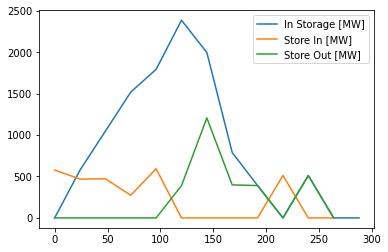

In [338]:
plt.plot(Ts+[Ts[-1]+24], in_storage.value, label="In Storage [MW]")
plt.plot(Ts, store_in.value, label="Store In [MW]")
plt.plot(Ts, store_out.value, label="Store Out [MW]")
plt.legend(loc="best")

In [215]:
# cons += [store_out[ii] <= M_*y[ii]] 

# for ii in range(N-1):
#     cons += [discharge_cost[ii] >= 10e6 * (y[ii+1]-y[ii])]
# for ii in range(n_sources-1):
#     for jj in range(N):
#         cons += [buy[ii,jj] <= y[ii, jj]]
#     cons += [cp.sum(y[ii,:]) <= 10.0]

# for ii in range(N-1):
#     cons += [start_up_cost[ii] >= cost_series[ii]*(y[ii+1]-y[ii])]
#     cons += [store_out[ii] <= M_*y[ii]]

# max_discharges = 1.0
# for ii in range(0,N,3):
#     min_idx, max_idx = ii, np.minimum(ii+3,N-1)
#     cons += [cp.sum(y[min_idx:max_idx]) <= max_discharges]